In [1]:
%run module.ipynb
# this already imports the following packages
# import numpy as np
# import pandas as pd  
import matplotlib.pyplot as plt

In [2]:
# helper functions to plot results

def plot_coefs(model,n_targets=3):
    feat = model.get_feature_names()
    for f in range(n_targets):
        # samples[f] is a pd dataframe
        samp = model.optimizer.samples[f]
        z_mean=samp['z'].mean()

        fig, axs = plt.subplots(2,10,figsize=[20,5])
        fig.suptitle("Regression for {}'".format(model.feature_names[f]))
        colors=plt.get_cmap('tab20')
        fig.tight_layout()
        for i in range(10):
            axs[0,i].hist(samp['beta'][str(i)],color=colors.colors[2*i])
            axs[0,i].set_title("Coef of {}".format(feat[i]))
            
            x = [z_mean[i],1-z_mean[i]]

            axs[1,i].pie(x,labels=["{:.0%}".format(x[0]),""],colors=[colors.colors[2*i],colors.colors[2*i+1]])
        axs[1,0].set_ylabel("% not masked")
    plt.show()

def plot_params(model,n_targets=3,n_bins=10):
    feat=model.get_feature_names()
    for f in range(n_targets):
        samp = model.optimizer.samples[f]
        fig,axs=plt.subplots(1,3,figsize=[10,3])
        fig.suptitle("Regression for {}'".format(model.feature_names[f]))
        fig.tight_layout()
        axs[0].hist(samp['sigma2'],color='blueviolet',bins=n_bins)
        axs[0].set_xlabel("$\sigma^2$")
        axs[0].set_title("mean: {:.2}".format(samp['sigma2'].values.mean()))
        axs[1].hist(samp['tau2'],color='royalblue',bins=n_bins)
        axs[1].set_xlabel("$\\tau^2$")
        axs[1].set_title("mean: {:.2}".format(samp['tau2'].values.mean()))
        axs[2].hist(samp['theta'],color='forestgreen',bins=n_bins)
        axs[2].set_xlabel("$\\theta$")
        axs[2].set_title("mean: {:.2}".format(samp['theta'].values.mean()))
    plt.show()



# Numerical experiments of the SBAM module

In this notebook, we will use the module we implemented in the `module.ipynb` notebook, and test it with data generated in the `data_generation.ipynb` notebook, examining its performance as we tamper with its hyperparameters.

## Rössler system test

We generated data accordingly to

$$
\begin{cases}
\dot{x} = -y -z \\ 
\dot{y} = x+ay \\
\dot{z} = b + z(x-c)
\end{cases}
$$

with parameters $a, b, c$ set as follow:

$$
\begin{cases}
a = 0.1 \\ 
b = 0.1 \\ 
c = 14
\end{cases}
$$

In [3]:
import pysindy as ps

# load data
r = np.load('./data/rossler_r.npy')
r_noisy = np.load("./data/rossler_r_noisy.npy")
t = np.load("./data/rossler_t.npy")

# r is shaped like (n_points,n_dimensions)
print("Data vector:")
print(r[:5])

# t is time axis
print("\n\nTime vector:")
print(t[:5])

feature_names = ['x','y','z'] # just a label for the features, instead of simply using x1,x2....

Data vector:
[[1.         1.         1.        ]
 [0.98056166 1.01090845 0.87893564]
 [0.96215121 1.02163858 0.77249533]
 [0.94463303 1.0321998  0.67893681]
 [0.9278878  1.04260026 0.59672081]]


Time vector:
[0.       0.010001 0.020002 0.030003 0.040004]


### Model hyperparameters

We can tune the hyperparameters of our model before running the sampler; these are stored as attributes by the class. First, let's try to set a uniform prior on $\theta$; since $\theta \in [0,1]$, we have $E[\theta]=0.5$; but $\theta$ represent the probability of a certain feature being "selected" with a non-zero coefficient, so setting a uniform prior like this means that we expect the number of total predictors to be around half of them.

In [4]:
# sampling length
iters = 2000
nr_burnin = 500

In [5]:
opt=SBAM(max_iter=iters,burn_in=nr_burnin,verbose=True)

# setting beta hyperparameters for theta
opt.a=1. 
opt.b=1.

# hyperparameter for tau2
opt.s=0.5

# hyperparameter for sigma2
opt.a1=0.01
opt.a2=0.001

model = ps.SINDy(feature_names=feature_names,optimizer=opt) 

# fit the model
model.fit(r,t=t)

Sampling for target n# 0/2...
|████████████████████████████████████████| 1999/1999 [100%] in 7.4s (271.28/s)                                          
Sampling for target n# 1/2...
|████████████████████████████████████████| 1999/1999 [100%] in 11.0s (181.04/s)                                         
Sampling for target n# 2/2...
|████████████████████████████████████████| 1999/1999 [100%] in 11.6s (172.50/s)                                         


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x', 'y', 'z'],
      optimizer=SBAM(burn_in=500, max_iter=2000, verbose=True))

### Results with uniform prior on $\theta$

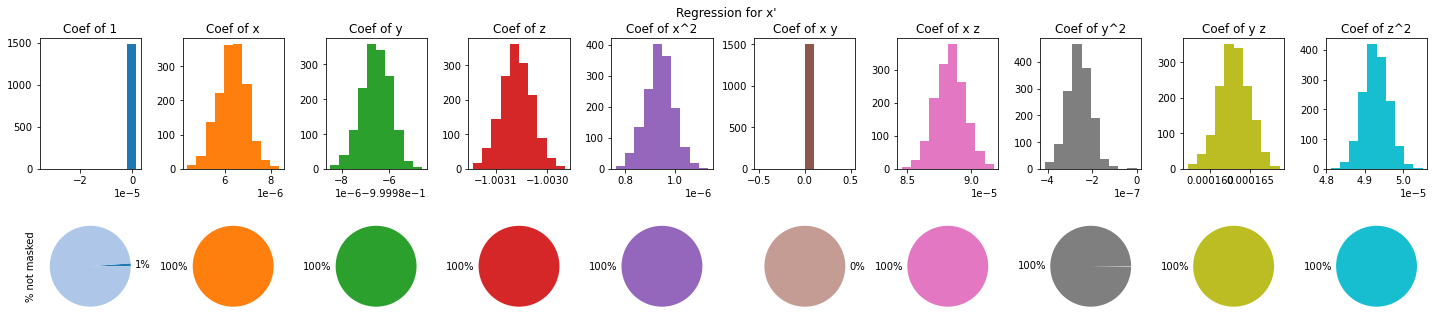

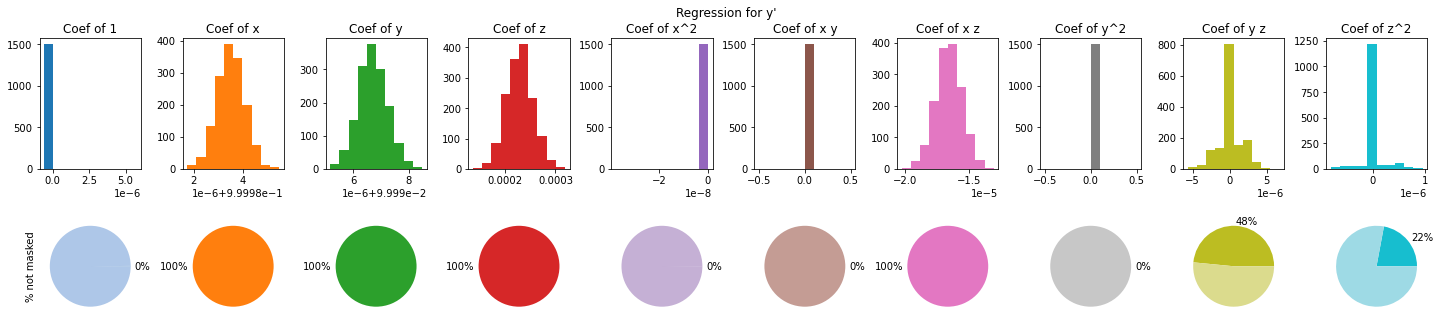

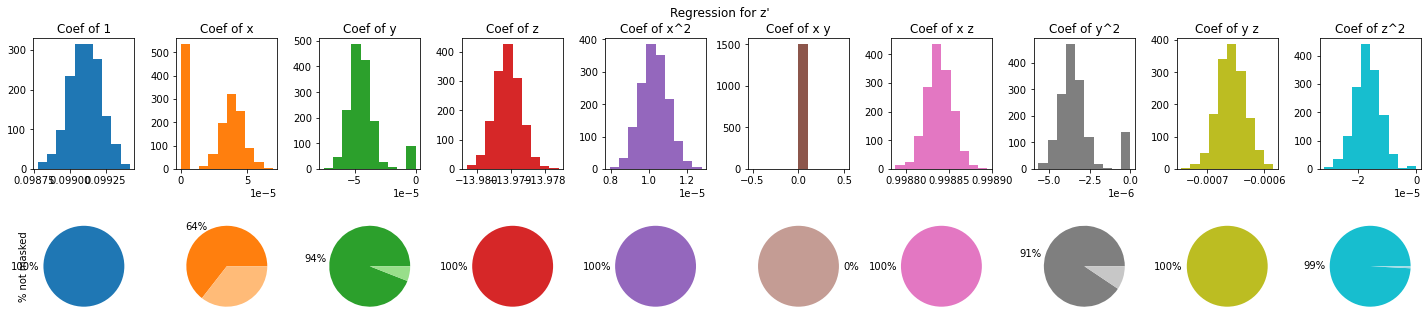

In [6]:
plot_coefs(model)

As we can see, for the features that we know are important (for instance, $y$ and $z$ in the expression for the $\dot{x}$), the samples are overwhelmingly drawn from the non-zero distribution, and their masking coefficient is always 1. But, for some other features that we know should not contribute to the expression, their sampling is also almost entirely coming from the conditional distribution $P(\beta_j|z_j=1)$; apparently, the library construction introduces some bias in the hyperplane that is enough for the likelihood to completely disrupt the coin toss in favour of the non-zero distribution.

Let us now adopt a better differentiation method by selecting a higher order in the differentiation algorithm:

In [7]:
opt=SBAM(max_iter=iters,burn_in=nr_burnin,verbose=True)

# setting beta hyperparameters for theta
opt.a=1. 
opt.b=1.

# hyperparameter for tau2
opt.s=0.5

# hyperparameter for sigma2
opt.a1=0.01
opt.a2=0.001

dif = ps.FiniteDifference(order=12)

model = ps.SINDy(feature_names=feature_names,optimizer=opt,differentiation_method=dif) 

# fit the model
model.fit(r,t=t)

Sampling for target n# 0/2...
|████████████████████████████████████████| 1999/1999 [100%] in 3.9s (514.74/s)                                          
Sampling for target n# 1/2...
|████████████████████████████████████████| 1999/1999 [100%] in 3.9s (514.32/s)                                          
Sampling for target n# 2/2...
|████████████████████████████████████████| 1999/1999 [100%] in 3.9s (512.23/s)                                          


SINDy(differentiation_method=FiniteDifference(order=12),
      feature_library=PolynomialLibrary(), feature_names=['x', 'y', 'z'],
      optimizer=SBAM(burn_in=500, max_iter=2000, verbose=True))

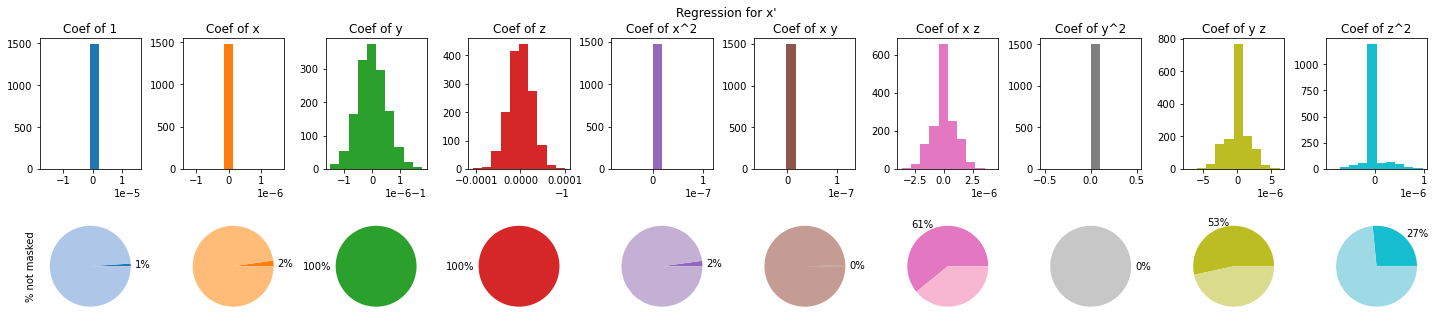

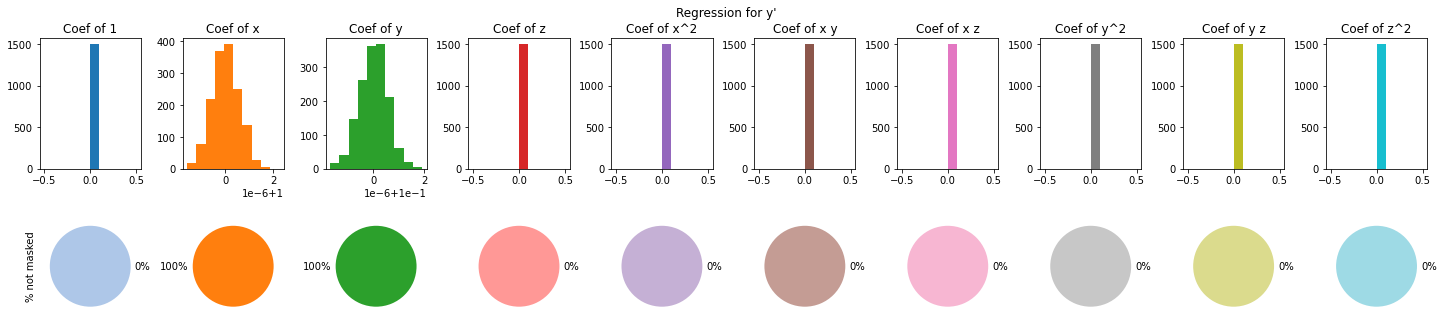

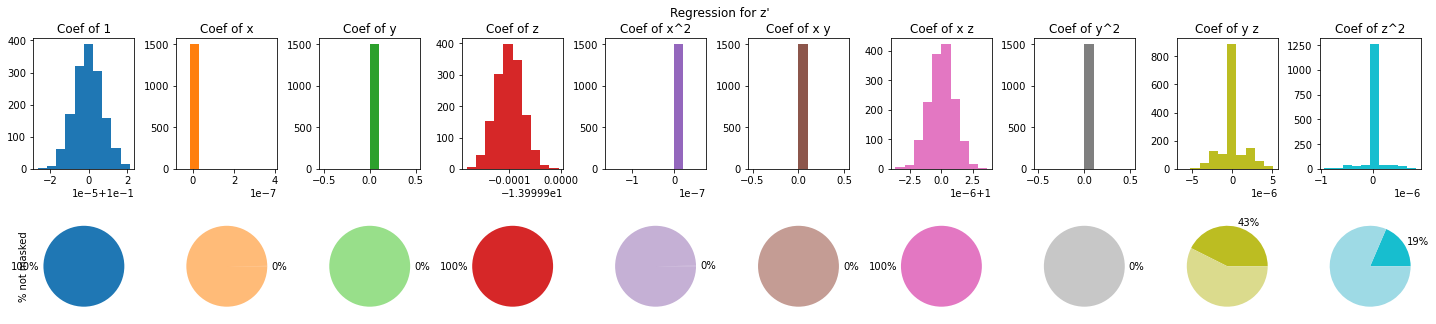

In [8]:
plot_coefs(model)

Evidently, the differentiation algorithm's improvement reduces the bias that was unbalancing the posterior distribution w.r.t. the actual system coefficients that we know. 

## Non uniform prior on $\theta$: sparsity

But let's come back to the prior assignment for $\theta$: we know that its prior distribution represents the belief that we have about what percentage of features would be important for predicting the time derivative. But if we construct a library of many candidates feature, we expect only few of them to be important: that is what the _sparsity_ belief is all about. We can quantify this by manipulating the Beta distribution hyperparameters for $\theta$: in particular, setting `opt.b` much larger than `opt.a` will result in a very skewed distribution towards zero; this way, the data has to be really convincing in order for the coin toss to be favourable towards the non-zero values. 

In [9]:
opt=SBAM(max_iter=iters,burn_in=nr_burnin,verbose=True)

# setting beta hyperparameters for theta
opt.a=1. 
opt.b=1e10

# hyperparameter for tau2
opt.s=0.5

# hyperparameter for sigma2
opt.a1=0.01
opt.a2=0.001

dif = ps.FiniteDifference(order=12)

model = ps.SINDy(feature_names=feature_names,optimizer=opt,differentiation_method=dif) 

# fit the model
model.fit(r,t=t)

Sampling for target n# 0/2...
|████████████████████████████████████████| 1999/1999 [100%] in 3.9s (512.67/s)                                          
Sampling for target n# 1/2...
|████████████████████████████████████████| 1999/1999 [100%] in 4.5s (441.64/s)                                          
Sampling for target n# 2/2...
|████████████████████████████████████████| 1999/1999 [100%] in 4.4s (454.42/s)                                          


SINDy(differentiation_method=FiniteDifference(order=12),
      feature_library=PolynomialLibrary(), feature_names=['x', 'y', 'z'],
      optimizer=SBAM(burn_in=500, max_iter=2000, verbose=True))

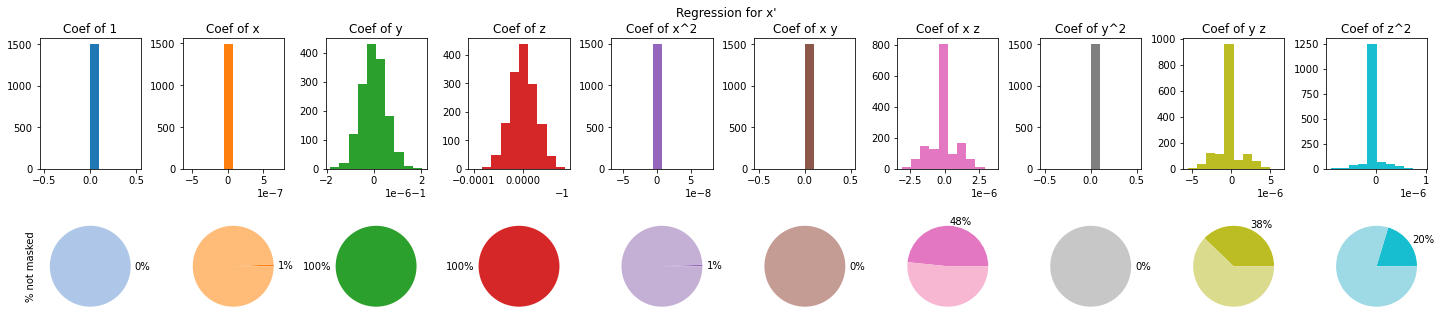

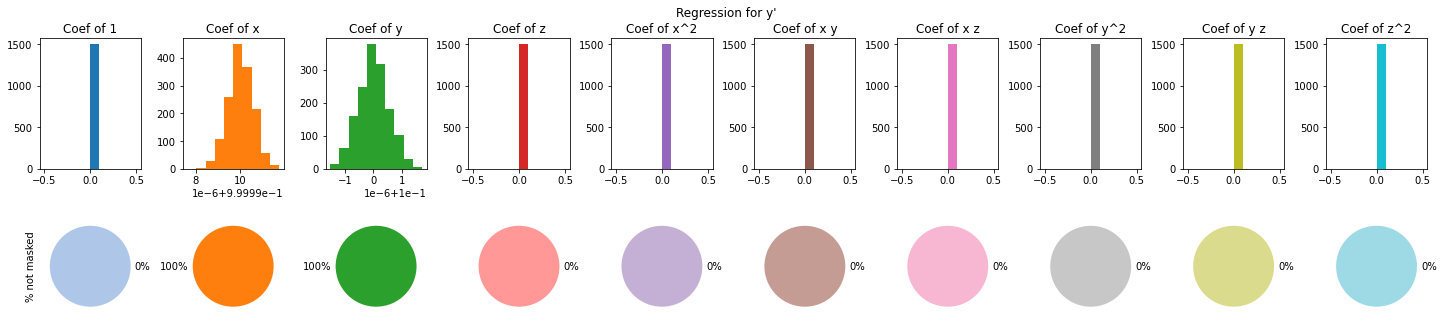

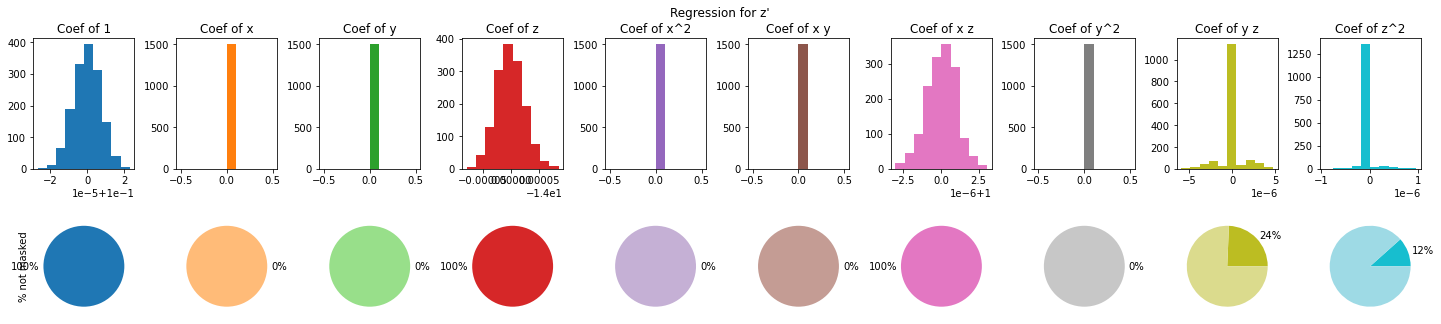

In [10]:
plot_coefs(model)

In [11]:
model.print()

(x)' = -1.000 y + -1.000 z
(y)' = 1.000 x + 0.100 y
(z)' = 0.100 1 + -14.000 z + 1.000 x z


## Lorenz system

The combination of prior hyperparameters and a proper choice of differentiation algorithm yields very good results, but we're to get a hunch that maybe the model is very sensitive to the library construction and the dataset. Let's see how it performs when being fed the dataset containing the trajectory of a Lorenz attractor, generated via the following parametrization:

$$
\begin{cases}
\dot{x} = \sigma(y-x) \\ 
\dot{y} = x(\rho - z) - y \\
\dot{z} = xy - \beta z
\end{cases}
$$

and

$$
\begin{cases}
\sigma = 10 \\ 
\rho = 28 \\ 
\beta = \frac{8}{3}
\end{cases}
$$

In [12]:
# load data
r = np.load('./data/lorenz_r.npy')
r_noisy = np.load("./data/lorenz_r_noisy.npy")
t = np.load("./data/lorenz_t.npy")

opt=SBAM(max_iter=iters,burn_in=nr_burnin,verbose=True)

# setting beta hyperparameters for theta
opt.a=1. 
opt.b=10000000000.

# hyperparameter for tau2
opt.s=0.5

# hyperparameter for sigma2
opt.a1=0.01
opt.a2=0.001

dif = ps.FiniteDifference(order=12)

model = ps.SINDy(feature_names=feature_names,optimizer=opt,differentiation_method=dif) 

# fit the model
model.fit(r,t=t)

Sampling for target n# 0/2...
|████████████████████████████████████████| 1999/1999 [100%] in 4.2s (472.68/s)                                          
Sampling for target n# 1/2...
|████████████████████████████████████████| 1999/1999 [100%] in 4.3s (467.94/s)                                          
Sampling for target n# 2/2...
|████████████████████████████████████████| 1999/1999 [100%] in 4.4s (455.03/s)                                          


SINDy(differentiation_method=FiniteDifference(order=12),
      feature_library=PolynomialLibrary(), feature_names=['x', 'y', 'z'],
      optimizer=SBAM(burn_in=500, max_iter=2000, verbose=True))

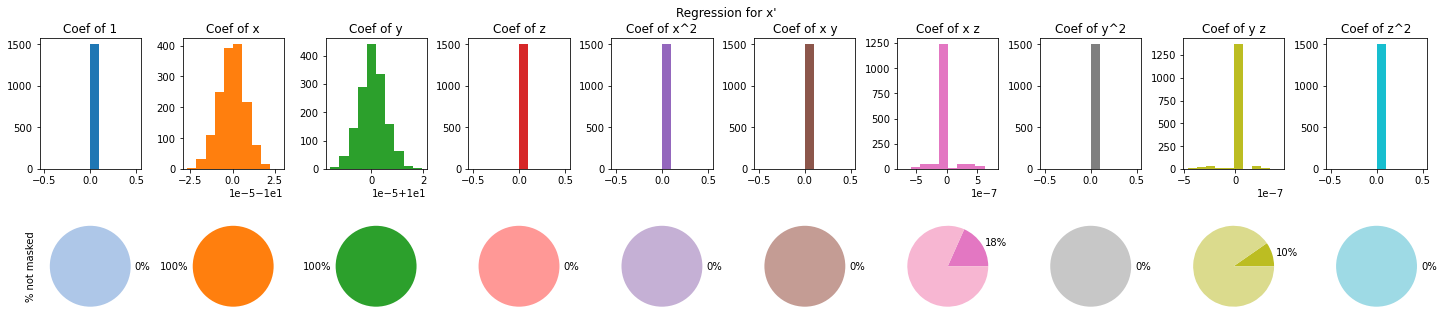

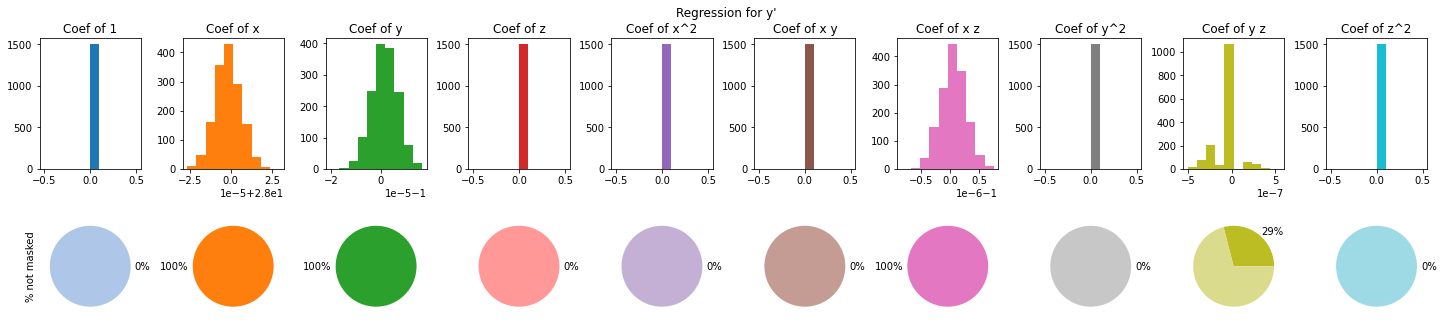

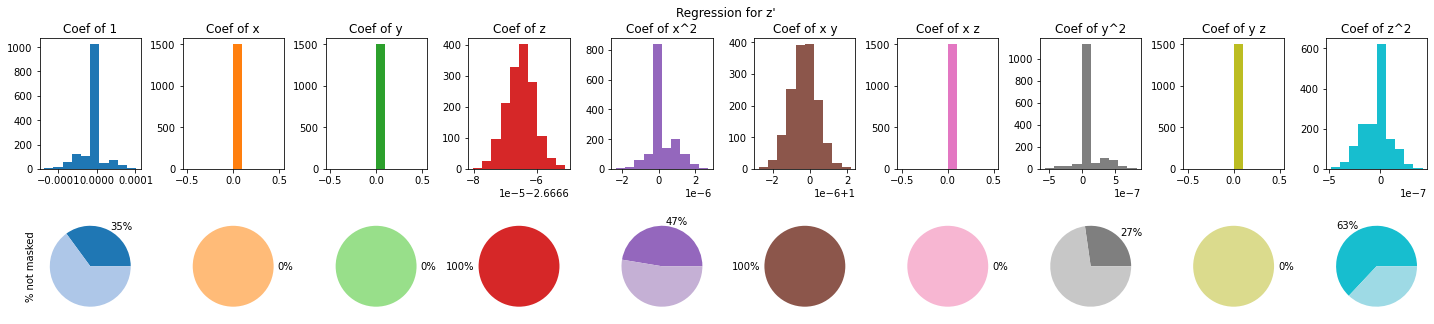

In [13]:
plot_coefs(model)

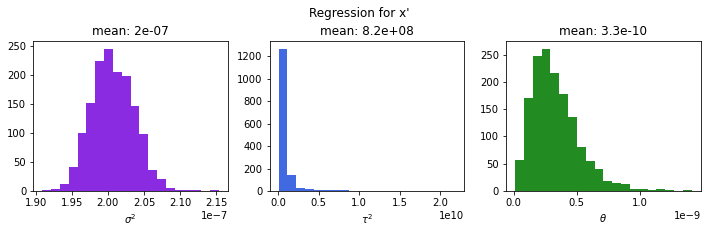

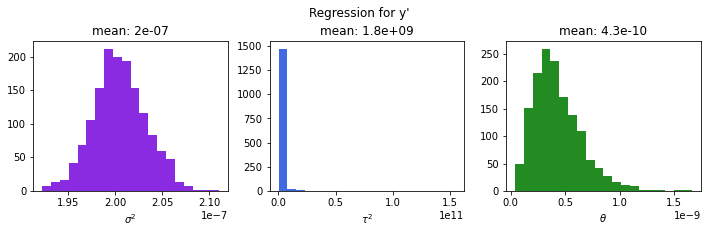

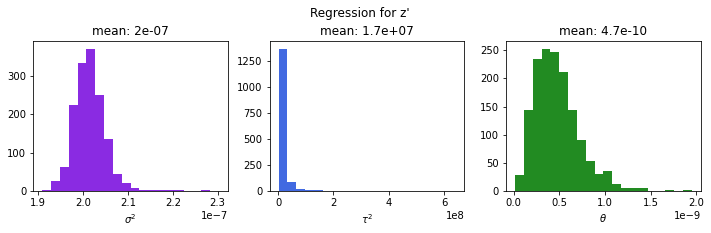

In [14]:
plot_params(model,n_bins=20)

In [15]:
model.print()

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


# Fewer data points

What if there were less data points available?

In [16]:
opt=SBAM(max_iter=iters,burn_in=nr_burnin,verbose=True)

# setting beta hyperparameters for theta
opt.a=1. 
opt.b=10000000000.

# hyperparameter for tau2
opt.s=0.5

# hyperparameter for sigma2
opt.a1=0.01
opt.a2=0.001

dif = ps.FiniteDifference(order=12)

model = ps.SINDy(feature_names=feature_names,optimizer=opt,differentiation_method=dif) 

N = 100

# fit the model
model.fit(r[:N],t=t[:N])

Sampling for target n# 0/2...
|████████████████████████████████████████| 1999/1999 [100%] in 2.4s (822.01/s)                                          
Sampling for target n# 1/2...
|████████████████████████████████████████| 1999/1999 [100%] in 2.7s (750.28/s)                                          
Sampling for target n# 2/2...
|████████████████████████████████████████| 1999/1999 [100%] in 2.7s (750.48/s)                                          


SINDy(differentiation_method=FiniteDifference(order=12),
      feature_library=PolynomialLibrary(), feature_names=['x', 'y', 'z'],
      optimizer=SBAM(burn_in=500, max_iter=2000, verbose=True))

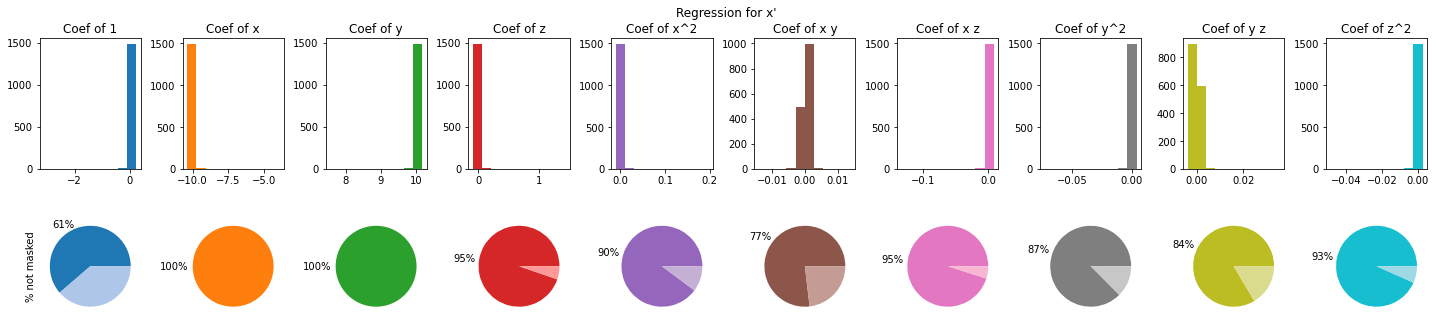

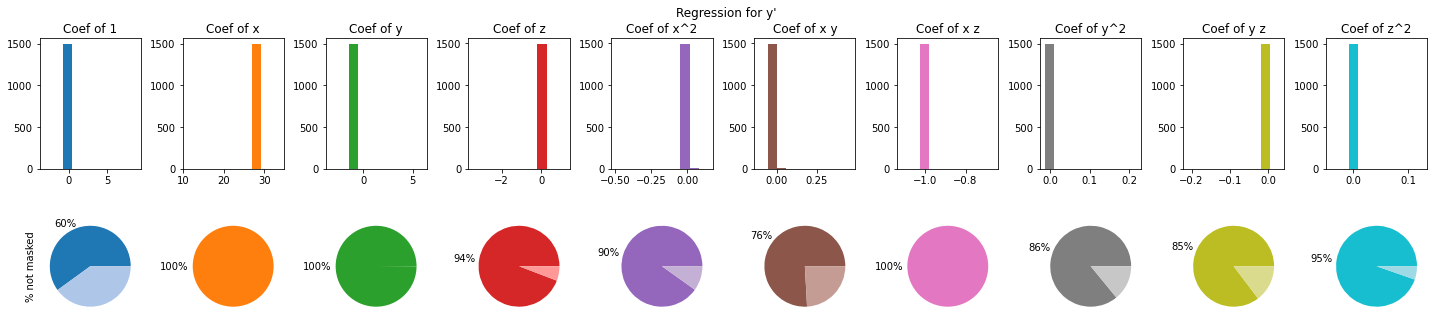

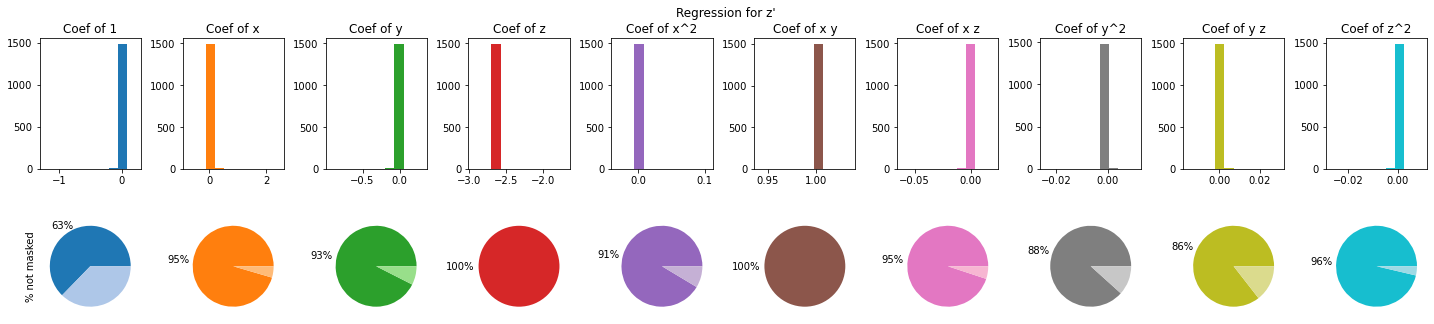

In [17]:
plot_coefs(model)

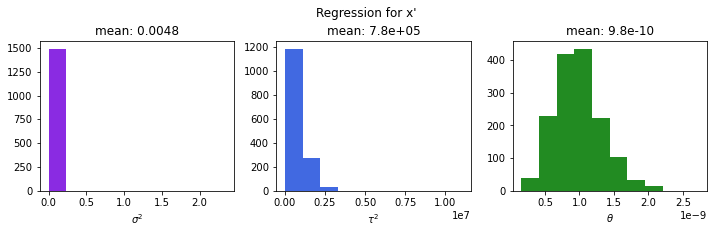

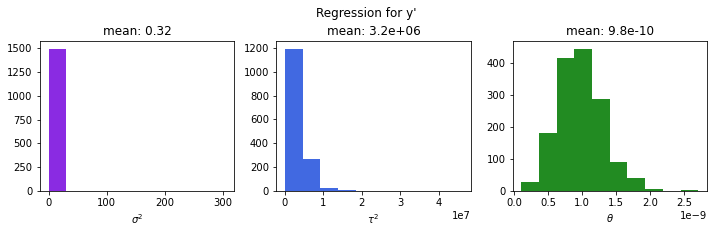

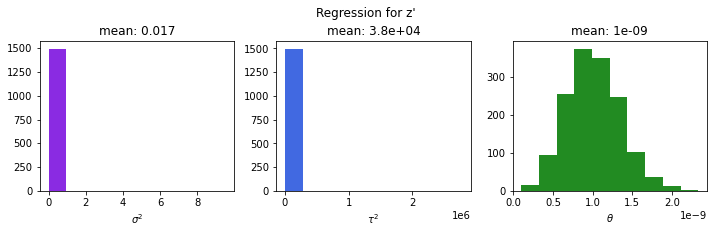

In [18]:
plot_params(model)

In [19]:
model.print()

(x)' = -10.000 x + 10.000 y
(y)' = 27.999 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


## Noisy data


In [20]:
model.fit(r_noisy,t=t)

Sampling for target n# 0/2...
|████████████████████████████████████████| 1999/1999 [100%] in 3.9s (513.80/s)                                          
Sampling for target n# 1/2...
|████████████████████████████████████████| 1999/1999 [100%] in 6.8s (293.50/s)                                          
Sampling for target n# 2/2...
|████████████████████████████████████████| 1999/1999 [100%] in 6.6s (301.29/s)                                          


SINDy(differentiation_method=FiniteDifference(order=12),
      feature_library=PolynomialLibrary(), feature_names=['x', 'y', 'z'],
      optimizer=SBAM(burn_in=500, max_iter=2000, verbose=True))

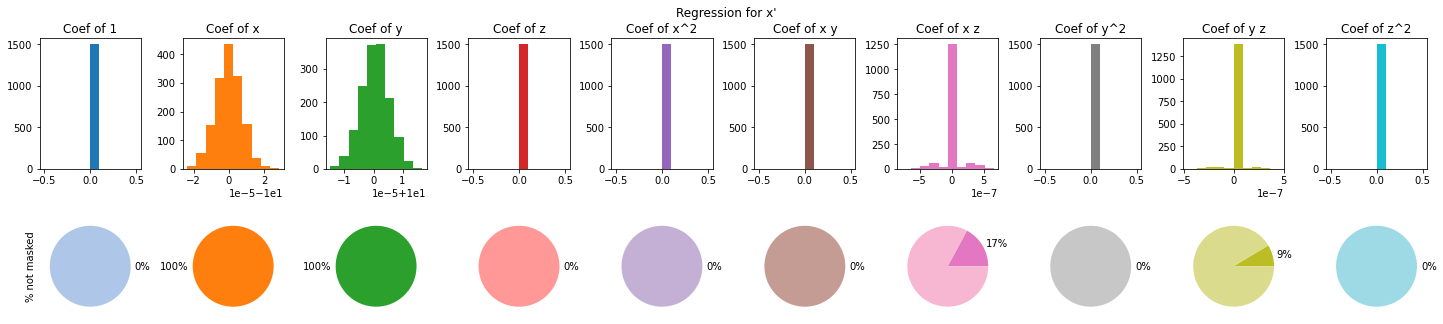

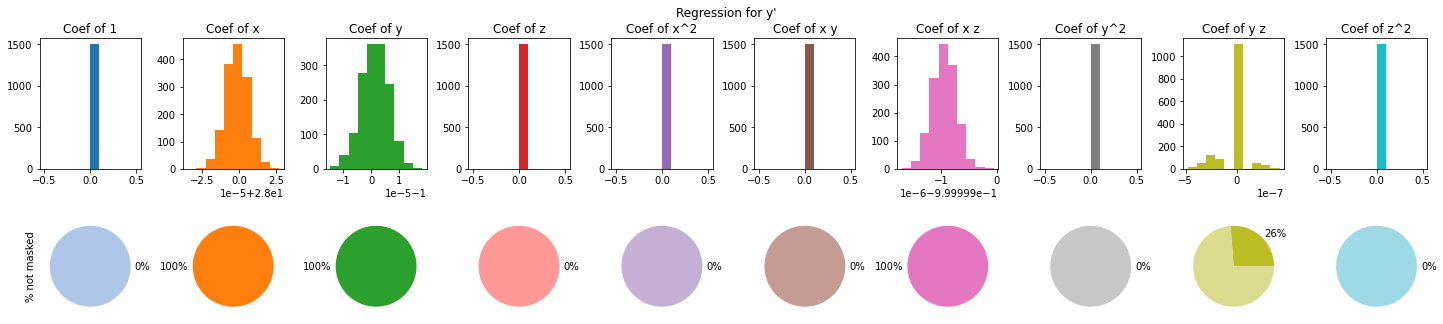

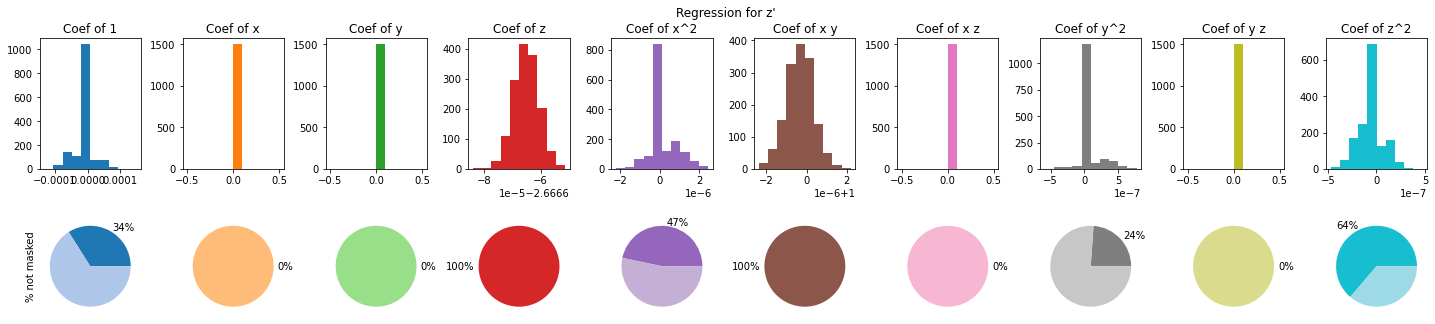

In [21]:
plot_coefs(model)

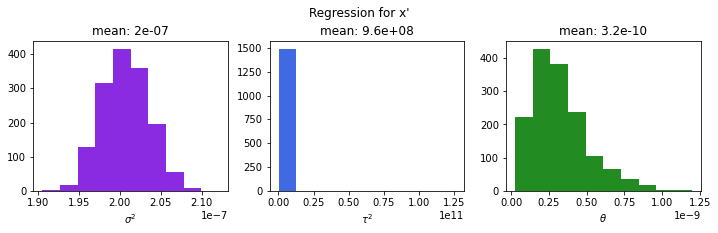

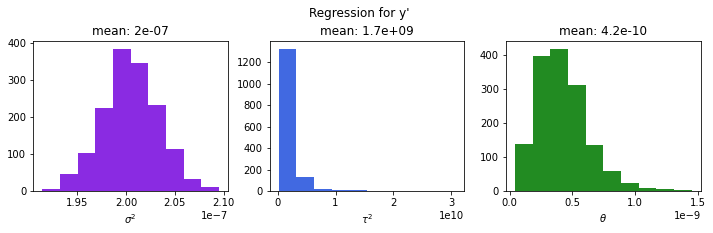

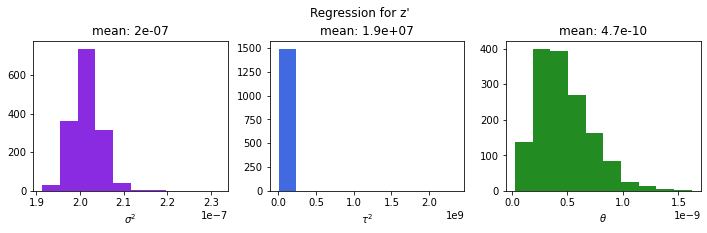

In [22]:
plot_params(model)

In [23]:
model.print()

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y
